# Vanishing Points and Lines
## Part 3

ابتدا همانند قسمت قبل، زوایای مورد نظر را به دست می‌آوریم. حال برای به دست آوردن هموگرفی، ابتدا باید نقاط را بازافکنش کنیم تا در فضای تصویری به دست آیند. سپس، ماتریس چرخش حول
محور $z$ و سپس ماتریس چرخش حول محور $x$ در آن ضرب شود و در نهایت به تصویر دوباره افکنده شود. این عملیات‌ها را به صورت ضرب زیر خلاصه می‌کنیم تا ماتریس هموگرفی به دست آید:

$$H = KR_xR_zK^{-1}$$

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering
from scipy.spatial.transform import Rotation

img_o = plt.imread('./data/hw3/vns.jpg')[:, 600:]


def my_metric(p1, p2):
    d = np.linalg.norm(p1 - p2)
    return np.pi / 2 - min(d, np.pi - d)


def auto_detect_axis_lines(src, sigma=5, morph=23, canny1=120, canny2=3 * 120, rho=1, theta=np.pi / 180,
                           hough_thresh=110, l2=True):
    src = src.copy()
    src = cv.GaussianBlur(src, (sigma, sigma), 0)
    src = cv.cvtColor(src, cv.COLOR_RGB2GRAY)
    src = cv.morphologyEx(src, cv.MORPH_OPEN, np.ones((morph, morph), dtype=np.uint8))
    edges = cv.Canny(src, canny1, canny2, L2gradient=l2)
    lines = cv.HoughLines(edges, rho, theta, hough_thresh)

    dists = np.array([[my_metric(a[0, 1], b[0, 1]) for b in lines] for a in lines])
    labels = SpectralClustering(n_clusters=3, random_state=0, affinity='precomputed').fit_predict(dists)

    return lines[labels == 0], lines[labels == 1], lines[labels == 2]


def find_intersection_by_lines(lines):
    A = np.zeros((len(lines), 2))
    b = np.zeros(len(lines))
    for i in range(len(lines)):
        r, theta = lines[i][0]
        A[i, :] = np.cos(theta), np.sin(theta)
        b[i] = r
    return np.round(np.append(np.linalg.lstsq(A, b, rcond=None)[0], [1])).astype(np.int)


lines_y, lines_z, lines_x = auto_detect_axis_lines(img_o)
vx = find_intersection_by_lines(lines_x)
vy = find_intersection_by_lines(lines_y)
vz = find_intersection_by_lines(lines_z)

In [3]:
def find_focal_principal(vpts):
    A = np.array([[vpts[0][0] - vpts[2][0], vpts[0][1] - vpts[2][1]],
                  [vpts[1][0] - vpts[2][0], vpts[1][1] - vpts[2][1]]])
    b = np.array([vpts[1][0] * (vpts[0][0] - vpts[2][0]) + vpts[1][1] * (vpts[0][1] - vpts[2][1]),
                  vpts[0][0] * (vpts[1][0] - vpts[2][0]) + vpts[0][1] * (vpts[1][1] - vpts[2][1])])
    p = np.linalg.solve(A, b)
    f2 = -p[0] ** 2 - p[1] ** 2 + (vpts[0][0] + vpts[1][0]) * p[0] + (vpts[0][1] + vpts[1][1]) * p[1] - (
            vpts[0][0] * vpts[1][0] + vpts[0][1] * vpts[1][1])
    return p, np.sqrt(f2)


p, f = find_focal_principal([vx, vy, vz])
K = np.array([[f, 0, p[0]],
              [0, f, p[1]],
              [0, 0, 1]])
Ki = np.linalg.inv(K)


In [4]:
nrm = np.cross(Ki @ vx, Ki @ vy)
nrm /= np.linalg.norm(nrm[:2])
zrd = np.arctan2(nrm[1], nrm[0]) + np.pi / 2
xrd = np.arcsin(nrm[2] / np.linalg.norm(nrm))

[[ 1.00045956e+00 -1.51638821e-02 -2.60857006e-02]
 [ 4.94792403e-02  1.00806818e+00 -9.97141388e+02]
 [ 7.50820704e-07  1.52968893e-05  9.75672530e-01]]


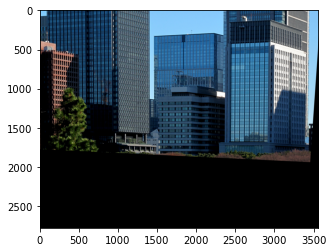

In [6]:
R = Rotation.from_euler('x', xrd).as_matrix() @ Rotation.from_euler('z', -zrd).as_matrix()
H = K @ R @ Ki
print(H)

res04 = cv.warpPerspective(img_o, H, img_o.shape[:2][::-1])
# res04
plt.imshow(res04)
plt.show()

